# Read DWD CDC Time Series, Merge with Station Description and Append 

The main idea behind this activity is to reformat and merge time series (here we use hourly precipitation) from the DWD Climate Data Center in such a way that it can be used with the **QGIS time manager extension**. 

This extension allows to filter an attribute table of a vector layer (e.g. points representing precipitation stations plus precipitation data) with a time stamp column. The extension limits the attribute table to the records matching the particular time stamp provided by the time manager extension (e.g. by the user moving the time slider). This selected subset of the attribute table is then used to change the sympology of the vector layer according to the variable of interest (e.g. precipitation rate).

The QGIS time manager extension approach is a bit brute force, because each individual measurement at a station at a given time is one feature (row in the table), i.e. a time series at station X with hourly resolution for a day (24 values) entails 24 different features with the same station id and the corresponding coordinates but different times. As of now this 1:n relationship can only be realized by importing a CSV file with the according structure. 

(At least I was not able to generate the required view on a 1:n relationship by merging a point vector layer with precipitation station locations and an imported CSV time series table.)

The final data format is a concatenation of time series together with geographic location in 2D (e.g. lat, lon). The required data format looks principly like this:


| station_id |        name        |   lat   |   lon  |        meas_time       | prec_rate |
|:----------:|:------------------:|:-------:|:------:|:----------------------:|:---------:|
|        ... | ...                |     ... |    ... |                    ... |       ... |
|       1595 | Gelsenkirchen-Buer | 51.5762 | 7.0652 | 2018-12-07T08:00:00UTC |       1.5 |
|       1595 | Gelsenkirchen-Buer | 51.5762 | 7.0652 | 2018-12-07T09:00:00UTC |       1.7 |
|       1595 | Gelsenkirchen-Buer | 51.5762 | 7.0652 | 2018-12-07T10:00:00UTC |       0.1 |
|        ... | ...                |     ... |    ... |                    ... |       ... |
|      13670 | Duisburg-Baerl     | 51.5088 | 6.7018 | 2018-12-07T08:00:00UTC |       0.8 |
|      13670 | Duisburg-Baerl     | 51.5088 | 6.7018 | 2018-12-07T09:00:00UTC |       0.4 |
|      13670 | Duisburg-Baerl     | 51.5088 | 6.7018 | 2018-12-07T10:00:00UTC |       0.0 |
|        ... | ...                |     ... |    ... |                    ... |       ... |


(Table generated with https://www.tablesgenerator.com/markdown_tables)

To achieve this the precipitation time series (station_id, meas_time, prec_rate) have to be merged with the station metadata (station_id, lat, lon) coming from the a CSV file generated in an earlier activity. We use Pandas to read, join and append the data to generate the final CSV file to be imported as a point layer to QGIS. 

This final data format is far from being optimal because of large size and highly redundant information. This is a challenge for QGIS which loses responsiveness with large data. To jsut show the principle it is advisable to limit to size of the problem. 

The following filters (selection criteria) are applied:

  * Precipitation stations in NRW only (approx. 127 stations) 
  * Hourly precipitation data
  * Time interval from 2018-12-01 to last date in precipitation data set 
  
Still: 40 days * 24 hrs / day * 127 stations = 121920 records leading to 121920 features in a point layer in QGIS. 

In fact, the resulting number of records is arround 91000. The reason might be that not all stations in the station list have time series. This has to be checked carefully.



## FTP Connection

### Connection Parameters

In [1]:
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""

### FTP Directory Definition and Station Description Filename Pattern

In [2]:
# The topic of interest.
topic_dir = "/hourly/precipitation/historical/"
#topic_dir = "/annual/kl/historical/"

# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"
ftp_dir =  ftp_climate_data_dir + topic_dir

### Local Directories

In [3]:
local_ftp_dir         = "data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_station_dir = local_ftp_dir + topic_dir # Local directory where local station info is located
local_ftp_ts_dir      = local_ftp_dir + topic_dir # Local directory where time series downloaded from ftp are located

local_generated_dir   = "data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_station_dir     = local_generated_dir + topic_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + topic_dir # Parallelly merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + topic_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin

In [4]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

data/original/DWD/
data/original/DWD//hourly/precipitation/historical/
data/original/DWD//hourly/precipitation/historical/

data/generated/DWD/
data/generated/DWD//hourly/precipitation/historical/
data/generated/DWD//hourly/precipitation/historical/
data/generated/DWD//hourly/precipitation/historical/


In [5]:
import os
os.makedirs(local_ftp_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir,exist_ok = True)
os.makedirs(local_ftp_ts_dir,exist_ok = True)

os.makedirs(local_generated_dir,exist_ok = True)
os.makedirs(local_station_dir,exist_ok = True)
os.makedirs(local_ts_merged_dir,exist_ok = True)
os.makedirs(local_ts_appended_dir,exist_ok = True)

### FTP Connect

In [6]:
import ftplib
ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd = passwd)
print(res)

230 Login successful.


In [7]:
ret = ftp.cwd(".")

In [8]:
#ftp.quit()

### FTP Grab File Function

In [9]:
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to chack the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")


### Generate Pandas Dataframe from FTP Directory Listing

In [10]:
import pandas as pd
import os

unique= []
def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:    
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
#        itemlist = [line[0:1], int(line[31:42]), line[56:]]
#        flist.append(itemlist)
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        #for new file structure. DWD has updated the files on 31st March, 2022 which contains the duplicates
        if fext == '.txt':
            flist.append([station_id, fname, fext, fsize, ftype])
            
        if station_id not in unique:
            flist.append([station_id, fname, fext, fsize, ftype])
            unique.append(station_id)
        #flist.append([station_id, fname, fext, fsize, ftype])   
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "name", "ext", "size", "type"])
    return(df_ftpdir)

In [11]:
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [12]:
df_ftpdir.head(10)

,station_id,name,ext,size,type
0,-1,BESCHREIBUNG_obsgermany_climate_hourly_precipi...,.pdf,166317,-
1,-1,RR_Stundenwerte_Beschreibung_Stationen.txt,.txt,303615,-
2,3,stundenwerte_RR_00003_19950901_20110401_hist.zip,.zip,418905,-
3,20,stundenwerte_RR_00020_20040814_20201231_hist.zip,.zip,432124,-
4,44,stundenwerte_RR_00044_20070401_20201231_hist.zip,.zip,354983,-
5,53,stundenwerte_RR_00053_20051001_20201231_hist.zip,.zip,385830,-
6,71,stundenwerte_RR_00071_20041022_20200101_hist.zip,.zip,402406,-
7,73,stundenwerte_RR_00073_20070401_20201231_hist.zip,.zip,357529,-
8,78,stundenwerte_RR_00078_20041101_20201231_hist.zip,.zip,421522,-
9,87,stundenwerte_RR_00087_20050201_20201231_hist.zip,.zip,403610,-


### Dataframe with TS Zip Files

In [13]:
#df_ftpdir["ext"]==".zip"
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.head(10)

,name,ext,size,type
station_id,,,,
3,stundenwerte_RR_00003_19950901_20110401_hist.zip,.zip,418905,-
20,stundenwerte_RR_00020_20040814_20201231_hist.zip,.zip,432124,-
44,stundenwerte_RR_00044_20070401_20201231_hist.zip,.zip,354983,-
53,stundenwerte_RR_00053_20051001_20201231_hist.zip,.zip,385830,-
71,stundenwerte_RR_00071_20041022_20200101_hist.zip,.zip,402406,-
73,stundenwerte_RR_00073_20070401_20201231_hist.zip,.zip,357529,-
78,stundenwerte_RR_00078_20041101_20201231_hist.zip,.zip,421522,-
87,stundenwerte_RR_00087_20050201_20201231_hist.zip,.zip,403610,-
91,stundenwerte_RR_00091_20040901_20201231_hist.zip,.zip,419182,-


### Download the Station Description File

In [14]:
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname)

RR_Stundenwerte_Beschreibung_Stationen.txt


In [15]:
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grabFile(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate//hourly/precipitation/historical/RR_Stundenwerte_Beschreibung_Stationen.txt
To:   data/original/DWD//hourly/precipitation/historical/RR_Stundenwerte_Beschreibung_Stationen.txt


In [16]:
# extract column names. They are in German (de)
# We have to use codecs because of difficulties with character encoding (German Umlaute)
import codecs

def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile,"r","utf-8")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
    
    translate = \
    {'Stations_id':'station_id',
     'von_datum':'date_from',
     'bis_datum':'date_to',
     'Stationshoehe':'altitude',
     'geoBreite': 'latitude',
     'geoLaenge': 'longitude',
     'Stationsname':'name',
     'Bundesland':'state'}
    
    colnames_en = [translate[h] for h in colnames_de]
    
    # Skip the first two rows and set the column names.
    df = pd.read_fwf(txtfile,skiprows=2,names=colnames_en, parse_dates=["date_from","date_to"],index_col = 0)
    
    # write csv
    df.to_csv(csvfile, sep = ";")
    return(df)

In [17]:
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
3,1995-09-01,2011-04-01,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
20,2004-08-14,2022-04-04,432,48.9219,9.9129,Abtsgm�nd-Untergr�ningen,Baden-W�rttemberg
29,2006-01-10,2022-04-04,260,49.7175,10.9101,Adelsdorf (Kl�ranlage),Bayern
44,2007-04-01,2022-04-04,44,52.9336,8.2370,Gro�enkneten,Niedersachsen
46,2006-01-03,2022-04-04,325,48.9450,12.4639,Aholfing,Bayern


### Select Stations Located in NRW from Station Description Dataframe

In [18]:
station_ids_selected = df_stations[df_stations['state'].str.contains("Nordrhein")].index
station_ids_selected

Int64Index([    3,   216,   326,   389,   390,   554,   555,   599,   603,
              613,
            ...
            14179, 14180, 14181, 14182, 14183, 14184, 14185, 14186, 14187,
            15000],
           dtype='int64', name='station_id', length=158)

In [19]:
# Create variable with TRUE if state is Nordrhein-Westfalen

# isNRW = df_stations['state'] == "Nordrhein-Westfalen"
isNRW = df_stations['state'].str.contains("Nordrhein")

# Create variable with TRUE if date_to is latest date (indicates operation up to now)
#isOperational = (df_stations['date_to'] >'2018-08-17 00:00:00')
isOperational = (df_stations['date_to'] >'2018-06-30 00:00:00')
isNotOperational = (df_stations['date_to'] <'2018-06-30 00:00:00')

# select on both conditions

dfNRW = df_stations[isNRW & isOperational]
dfNRW_nonOperational = df_stations[isNRW & isNotOperational]
#print("Number of stations in NRW: \n", dfNRW.count())

#dfNRW
roi = [216,2947,5468,7330,6264,4488,2483,3215,1300]
#dfNRW = dfNRW.loc[roi]
#dfNRW
dfNRW_nonOperational

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
3,1995-09-01,2011-04-01,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
326,2004-07-01,2013-07-08,120,51.7204,8.0577,Beckum-Unterberg,Nordrhein-Westfalen
599,1995-09-01,1999-03-02,62,50.7055,7.1467,Bonn-Friesdorf,Nordrhein-Westfalen
2703,1995-09-01,2000-10-10,496,51.8550,9.3239,K�terberg,Nordrhein-Westfalen
5719,2004-10-01,2009-12-10,235,51.2051,7.2000,Remscheid,Nordrhein-Westfalen


In [20]:
print(df_zips)

                                                        name   ext    size  \
station_id                                                                   
3           stundenwerte_RR_00003_19950901_20110401_hist.zip  .zip  418905   
20          stundenwerte_RR_00020_20040814_20201231_hist.zip  .zip  432124   
44          stundenwerte_RR_00044_20070401_20201231_hist.zip  .zip  354983   
53          stundenwerte_RR_00053_20051001_20201231_hist.zip  .zip  385830   
71          stundenwerte_RR_00071_20041022_20200101_hist.zip  .zip  402406   
...                                                      ...   ...     ...   
15810       stundenwerte_RR_15810_20180601_20201231_hist.zip  .zip   69532   
19140       stundenwerte_RR_19140_20201101_20201231_hist.zip  .zip    9708   
19171       stundenwerte_RR_19171_20200901_20201231_hist.zip  .zip   12514   
19172       stundenwerte_RR_19172_20200901_20201231_hist.zip  .zip   14631   
19299       stundenwerte_RR_19299_20210401_20211231_hist.zip  .z

### Download TS Data from FTP Server

Problem: Not all stations listed in the station description file are associated with a time series (zip file)! The stations in the description file and the set of stations whoch are TS data provided for (zip files) do not match perfectly.  

In [21]:
list(dfNRW.index)

[216,
 389,
 390,
 554,
 555,
 603,
 613,
 617,
 644,
 796,
 871,
 902,
 934,
 989,
 1024,
 1046,
 1078,
 1241,
 1246,
 1300,
 1303,
 1327,
 1590,
 1595,
 1766,
 2027,
 2110,
 2254,
 2473,
 2483,
 2497,
 2629,
 2667,
 2810,
 2947,
 2968,
 2999,
 3028,
 3031,
 3081,
 3098,
 3215,
 3321,
 3328,
 3339,
 3499,
 3540,
 3591,
 3795,
 3913,
 4063,
 4127,
 4150,
 4154,
 4313,
 4368,
 4371,
 4400,
 4488,
 4692,
 4741,
 4849,
 5064,
 5347,
 5360,
 5468,
 5480,
 5513,
 5619,
 5699,
 5717,
 5733,
 6041,
 6042,
 6043,
 6044,
 6045,
 6046,
 6047,
 6048,
 6049,
 6050,
 6051,
 6052,
 6053,
 6054,
 6055,
 6057,
 6058,
 6059,
 6060,
 6061,
 6064,
 6067,
 6197,
 6264,
 6276,
 6313,
 6337,
 7106,
 7330,
 7344,
 7374,
 7378,
 13669,
 13670,
 13671,
 13696,
 13700,
 13713,
 14096,
 14142,
 14143,
 14144,
 14145,
 14146,
 14147,
 14148,
 14149,
 14150,
 14151,
 14152,
 14153,
 14154,
 14155,
 14156,
 14158,
 14159,
 14164,
 14165,
 14166,
 14167,
 14168,
 14169,
 14170,
 14171,
 14172,
 14173,
 14174,
 14175

In [22]:
# Add the names of the zip files only to a list. 
local_zip_list = []

station_ids_selected = list(dfNRW.index)
for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        print(fname) 
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)


stundenwerte_RR_00216_20041001_20201231_hist.zip
stundenwerte_RR_00389_20091101_20201231_hist.zip
stundenwerte_RR_00390_20040701_20201231_hist.zip
stundenwerte_RR_00554_19950901_20201231_hist.zip
stundenwerte_RR_00555_20080101_20181101_hist.zip
stundenwerte_RR_00603_19990303_20201231_hist.zip
stundenwerte_RR_00613_20041101_20201231_hist.zip
stundenwerte_RR_00617_20040601_20201231_hist.zip
stundenwerte_RR_00644_20050101_20201231_hist.zip
stundenwerte_RR_00796_20041101_20201231_hist.zip
stundenwerte_RR_00871_20050801_20201231_hist.zip
stundenwerte_RR_00902_20061001_20201231_hist.zip
stundenwerte_RR_00934_20041001_20201231_hist.zip
stundenwerte_RR_00989_20050201_20201231_hist.zip
stundenwerte_RR_01024_20060801_20201231_hist.zip
stundenwerte_RR_01046_20041001_20201231_hist.zip
stundenwerte_RR_01078_19950901_20201231_hist.zip
stundenwerte_RR_01241_20061201_20201231_hist.zip
stundenwerte_RR_01246_20150801_20201231_hist.zip
stundenwerte_RR_01300_20040601_20201231_hist.zip
stundenwerte_RR_0130

### Join (Merge) the Time Series Columns

https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd


In [23]:
from datetime import datetime

def prec_ts_to_df(fname):
    
    dateparse = lambda dates: [datetime.strptime(str(d), '%Y%m%d%H') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])
    
    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [24]:
from zipfile import ZipFile

In [25]:
# PRECIPITATION
def prec_ts_merge():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = prec_ts_to_df(myfile)
                s = dftmp["r1"].rename(dftmp["stations_id"][0]).to_frame()
                # outer merge.
                df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

    #df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [26]:
df_merged_ts = prec_ts_merge()

Zip archive: data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00216_20041001_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041001_20201231_00216.txt



<ipython-input-23-72698e6dce7a>:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')


Zip archive: data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00389_20091101_20201231_hist.zip
Extract product file: produkt_rr_stunde_20091101_20201231_00389.txt

Zip archive: data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00390_20040701_20201231_hist.zip
Extract product file: produkt_rr_stunde_20040701_20201231_00390.txt

Zip archive: data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00554_19950901_20201231_hist.zip
Extract product file: produkt_rr_stunde_19950901_20201231_00554.txt

Zip archive: data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00555_20080101_20181101_hist.zip
Extract product file: produkt_rr_stunde_20080101_20181101_00555.txt

Zip archive: data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00603_19990303_20201231_hist.zip
Extract product file: produkt_rr_stunde_19990303_20201231_00603.txt

Zip archive: data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00613_2004

In [27]:
df_merged_ts.shape

(222009, 88)

In [28]:
startdate = pd.to_datetime("2018-04-16").date()
enddate = pd.to_datetime("2018-08-16").date()
#check = df_merged_ts[3215].loc[startdate:enddate]
check = df_merged_ts[roi].loc[startdate:enddate]
check = check.groupby(by = [check.index.date]).sum()
check = check.cumsum()
check

,216,2947,5468,7330,6264,4488,2483,3215,1300
2018-04-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-04-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-04-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-04-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-04-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2018-08-12,255.5,278.5,144.6,212.4,124.3,243.9,208.6,174.2,179.8
2018-08-13,273.2,290.7,150.9,213.4,131.4,261.3,219.9,189.1,199.6
2018-08-14,273.7,291.1,152.1,214.2,132.9,261.8,222.2,189.3,201.8
2018-08-15,273.7,291.1,152.1,214.2,132.9,261.8,222.2,189.3,201.8


In [29]:
#sum of each days data
abc = df_merged_ts.groupby(by = [df_merged_ts.index.date]).sum()
abc

,216,389,390,554,555,603,613,617,644,796,...,7344,7374,7378,13669,13670,13671,13696,13700,13713,15000
1995-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1995-09-02,0.0,0.0,0.0,12.4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1995-09-03,0.0,0.0,0.0,1.6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1995-09-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1995-09-05,0.0,0.0,0.0,2.8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,11.1,6.7,5.2,17.3,0.0,0.4,0.6,17.8,0.9,8.9,...,5.7,16.9,0.4,5.6,20.2,0.4,4.7,16.6,12.4,5.1
2020-12-28,3.6,4.7,4.3,2.8,0.0,0.0,0.4,3.3,0.1,3.2,...,1.7,2.2,3.0,5.1,3.6,2.0,2.6,1.9,3.7,2.0
2020-12-29,0.6,0.3,0.3,1.3,0.0,0.0,0.0,1.0,0.0,0.3,...,0.0,0.6,0.0,0.9,0.1,0.2,0.4,0.0,1.0,0.0
2020-12-30,1.5,0.5,0.9,0.6,0.0,0.5,0.2,0.7,2.1,1.0,...,0.4,0.0,0.1,1.6,0.4,1.3,1.2,1.7,1.8,0.5


In [30]:
startdate = pd.to_datetime("2018-04-16").date()
enddate = pd.to_datetime("2018-08-16").date()
efg = abc.loc[startdate:enddate]

In [31]:
total_cumsum = efg.cumsum()
total_cumsum

total_sum = efg[roi]
total_sum
#total_cumsum

,216,2947,5468,7330,6264,4488,2483,3215,1300
2018-04-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-04-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-04-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-04-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-04-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2018-08-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-08-13,17.7,12.2,6.3,1.0,7.1,17.4,11.3,14.9,19.8
2018-08-14,0.5,0.4,1.2,0.8,1.5,0.5,2.3,0.2,2.2
2018-08-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
filepathname = local_ts_merged_dir + "prec_ts_merged_nrw.csv"
filepathname2 = local_ts_merged_dir + "prec_ts_merged_nrw_4months_cumsum.csv"
filepathname3 = local_ts_merged_dir + "prec_ts_merged_ROI_4months.csv"
print("df_merged_ts is saved to: %s" % (filepathname))
df_merged_ts.to_csv(filepathname,sep=";")
total_cumsum.to_csv(filepathname2,sep=";")
df_merged_ts[roi].loc[startdate:enddate].to_csv(filepathname3,sep=";")

df_merged_ts is saved to: data/generated/DWD//hourly/precipitation/historical/prec_ts_merged_nrw.csv


In [33]:
import matplotlib.pyplot as plt

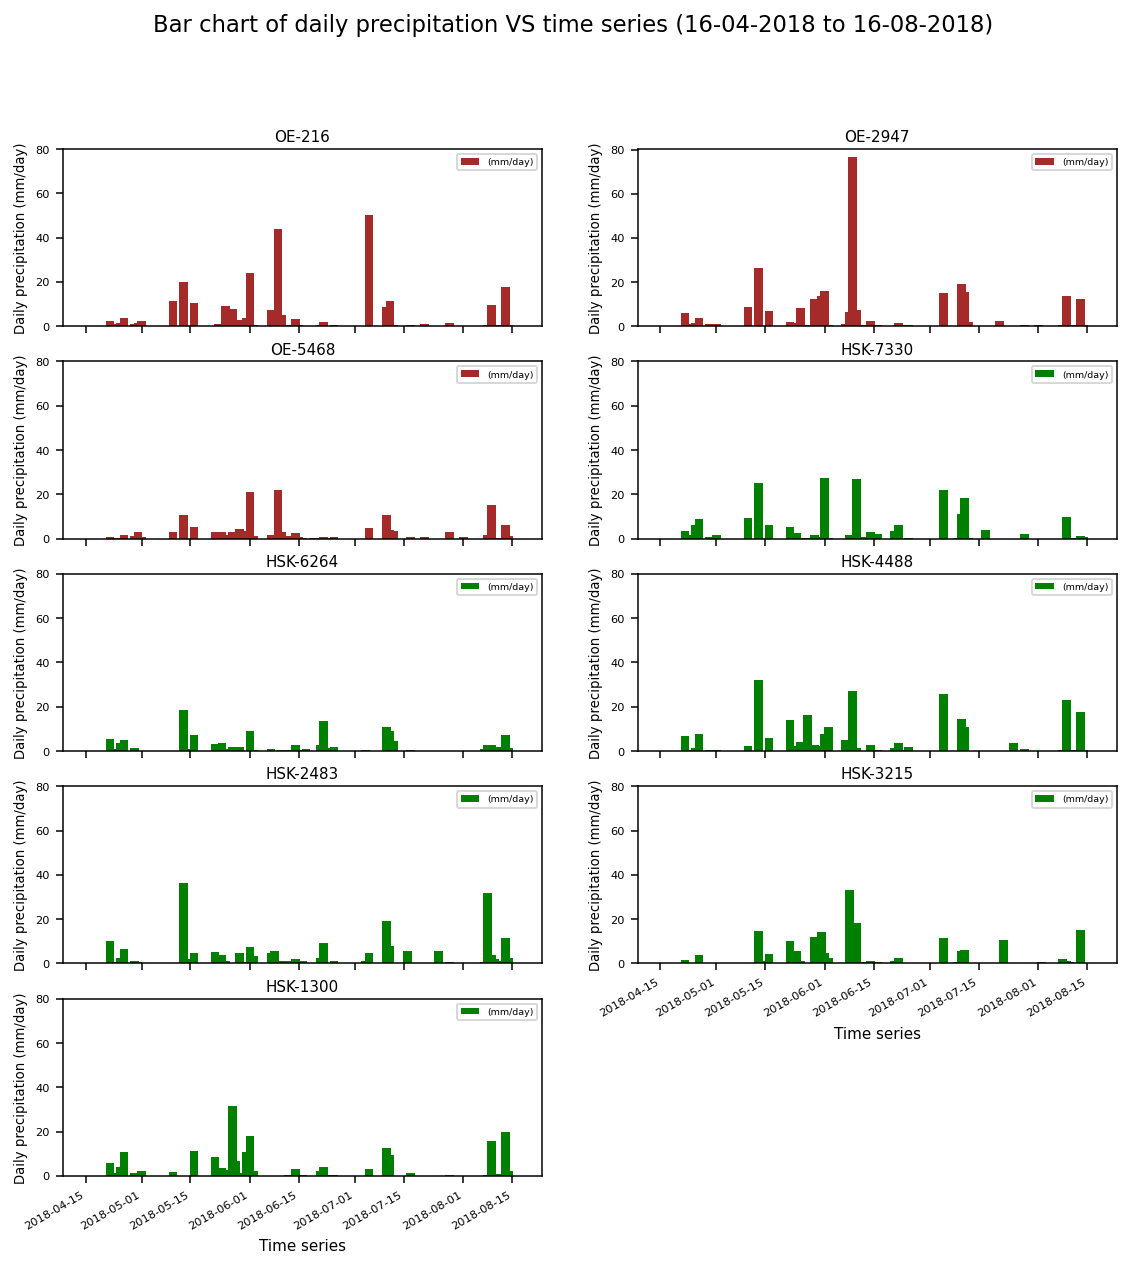

In [34]:
fig = plt.figure(dpi= 136, figsize=(10,10))

ax1 = fig.add_subplot(521)
ax2 = fig.add_subplot(522)
ax3 = fig.add_subplot(523)

ax4 = fig.add_subplot(524)
ax5 = fig.add_subplot(525)
ax6 = fig.add_subplot(526)
ax7 = fig.add_subplot(527)

ax8 = fig.add_subplot(528)
ax9 = fig.add_subplot(529)

ax1.set_xticklabels([])
ax2.set_xticklabels([])

ax3.set_xticklabels([])
ax4.set_xticklabels([])

ax5.set_xticklabels([])
ax6.set_xticklabels([])
ax7.set_xticklabels([])

ax1.set_ylabel('Daily precipitation (mm/day)', fontsize=7)
ax4.set_ylabel('Daily precipitation (mm/day)', fontsize=7)
ax7.set_ylabel('Daily precipitation (mm/day)', fontsize=7)

ax2.set_ylabel('Daily precipitation (mm/day)', fontsize=7)
ax3.set_ylabel('Daily precipitation (mm/day)', fontsize=7)
ax5.set_ylabel('Daily precipitation (mm/day)', fontsize=7)
ax6.set_ylabel('Daily precipitation (mm/day)', fontsize=7)
ax8.set_ylabel('Daily precipitation (mm/day)', fontsize=7)
ax9.set_ylabel('Daily precipitation (mm/day)', fontsize=7)

ax8.set_xlabel('Time series', fontsize=8)
ax9.set_xlabel('Time series', fontsize=8)

plt.setp(ax8.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax9.get_xticklabels(), rotation=30, horizontalalignment='right')

ax1.yaxis.set_tick_params(labelsize=6)
ax2.yaxis.set_tick_params(labelsize=6)
ax3.yaxis.set_tick_params(labelsize=6)
ax4.yaxis.set_tick_params(labelsize=6)
ax5.yaxis.set_tick_params(labelsize=6)
ax6.yaxis.set_tick_params(labelsize=6)
ax7.yaxis.set_tick_params(labelsize=6)
ax8.yaxis.set_tick_params(labelsize=6)
ax9.yaxis.set_tick_params(labelsize=6)

ax7.xaxis.set_tick_params(labelsize=6)
ax8.xaxis.set_tick_params(labelsize=6)
ax9.xaxis.set_tick_params(labelsize=6)

ax1.bar(total_cumsum.index.values, total_sum[216], color='brown', width = 2.5)

ax2.bar(total_cumsum.index.values, total_sum[2947], color='brown', width = 2.5)
ax3.bar(total_cumsum.index.values, total_sum[5468], color='brown', width = 2.5)

ax4.bar(total_cumsum.index.values, total_sum[7330], color='green', width = 2.5)
ax5.bar(total_cumsum.index.values, total_sum[6264], color='green', width = 2.5)

ax6.bar(total_cumsum.index.values, total_sum[4488], color='green', width = 2.5)
ax7.bar(total_cumsum.index.values, total_sum[2483], color='green', width = 2.5)

ax8.bar(total_cumsum.index.values, total_sum[3215], color='green', width = 2.5)
ax9.bar(total_cumsum.index.values, total_sum[1300], color='green', width = 2.5)

ax1.set(yticks=list(range(0,100,20)))

ax2.set(yticks=list(range(0,100,20)))
ax3.set(yticks=list(range(0,100,20)))

ax4.set(yticks=list(range(0,100,20)))
ax5.set(yticks=list(range(0,100,20)))

ax6.set(yticks=list(range(0,100,20)))
ax7.set(yticks=list(range(0,100,20)))

ax8.set(yticks=list(range(0,100,20)))
ax9.set(yticks=list(range(0,100,20)))


ax1.legend(['(mm/day)'],prop={'size': 5})

ax2.legend(['(mm/day)'],prop={'size': 5})
ax3.legend(['(mm/day)'],prop={'size': 5})

ax4.legend(['(mm/day)'],prop={'size': 5})
ax5.legend(['(mm/day)'],prop={'size': 5})

ax6.legend(['(mm/day)'],prop={'size': 5})
ax7.legend(['(mm/day)'],prop={'size': 5})

ax8.legend(['(mm/day)'],prop={'size': 5})
ax9.legend(['(mm/day)'],prop={'size': 5})


fig.suptitle('Bar chart of daily precipitation VS time series (16-04-2018 to 16-08-2018)')

ax1.text(x=0.5, y=1.025, s='OE-216', fontsize=8, weight='normal', ha='center', va='bottom', transform=ax1.transAxes)

ax2.text(x=0.5, y=1.025, s='OE-2947', fontsize=8, weight='normal', ha='center', va='bottom', transform=ax2.transAxes)
ax3.text(x=0.5, y=1.025, s='OE-5468', fontsize=8, weight='normal', ha='center', va='bottom', transform=ax3.transAxes)

ax4.text(x=0.5, y=1.025, s='HSK-7330', fontsize=8, weight='normal', ha='center', va='bottom', transform=ax4.transAxes)
ax5.text(x=0.5, y=1.025, s='HSK-6264', fontsize=8, weight='normal', ha='center', va='bottom', transform=ax5.transAxes)

ax6.text(x=0.5, y=1.025, s='HSK-4488', fontsize=8, weight='normal', ha='center', va='bottom', transform=ax6.transAxes)
ax7.text(x=0.5, y=1.025, s='HSK-2483', fontsize=8, weight='normal', ha='center', va='bottom', transform=ax7.transAxes)

ax8.text(x=0.5, y=1.025, s='HSK-3215', fontsize=8, weight='normal', ha='center', va='bottom', transform=ax8.transAxes)
ax9.text(x=0.5, y=1.025, s='HSK-1300', fontsize=8, weight='normal', ha='center', va='bottom', transform=ax9.transAxes)

#14170
#14171 active but no data available
plt.savefig('C:/Users/tazbi/Downloads/Geoinformatics/Exam/MIE_2.02_WS2021_II_Exam-master/exercise_4/Bar Chart of cumulative precipitation VS time series')

plt.show()

In [35]:
checkdate1 = pd.to_datetime("2018-04-16").date()
checkdate2 = pd.to_datetime("2018-05-16").date()
checkdate3 = pd.to_datetime("2018-06-16").date()
checkdate4 = pd.to_datetime("2018-07-16").date()
checkdate5 = pd.to_datetime("2018-08-16").date()

c1 = total_sum.loc[checkdate2 : checkdate3] #2018-05-16
c1

,216,2947,5468,7330,6264,4488,2483,3215,1300
2018-05-16,10.6,6.8,5.2,6.1,7.1,5.7,4.5,4.2,11.3
2018-05-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-22,0.0,2.0,2.9,5.4,3.2,14.0,5.3,9.9,8.4
2018-05-23,0.9,0.5,0.7,0.0,0.8,1.1,3.8,0.9,0.2
2018-05-24,1.0,1.6,2.8,2.7,3.6,2.1,3.7,5.8,3.6
2018-05-25,9.2,8.3,1.4,0.1,0.8,3.9,1.1,1.0,2.7


In [36]:
c2 = total_sum.loc[checkdate3] #2018-06-16
c2

216     0.2
2947    0.5
5468    0.3
7330    1.9
6264    0.6
4488    0.6
2483    1.0
3215    0.6
1300    0.3
Name: 2018-06-16, dtype: float64

In [37]:
c3 = total_sum.loc[checkdate4] #2018-07-16
c3

216     0.0
2947    0.0
5468    0.0
7330    0.0
6264    0.0
4488    0.0
2483    5.4
3215    0.0
1300    0.0
Name: 2018-07-16, dtype: float64

In [38]:
hk = [7730,6264,4488,2483,3215,1300]
olp = [216,2947,5468]

monthly_data_olp_june = total_sum[olp].loc[checkdate2:checkdate3]
monthly_data_olp_june.max()

216     44.0
2947    76.5
5468    21.8
dtype: float64

In [39]:
hk = [7330,6264,4488,2483,3215,1300]
monthly_data_hsk_june = total_sum[hk].loc[checkdate2:checkdate3]
monthly_data_hsk_june.max()

7330    27.5
6264     9.1
4488    27.3
2483     7.5
3215    33.0
1300    31.6
dtype: float64

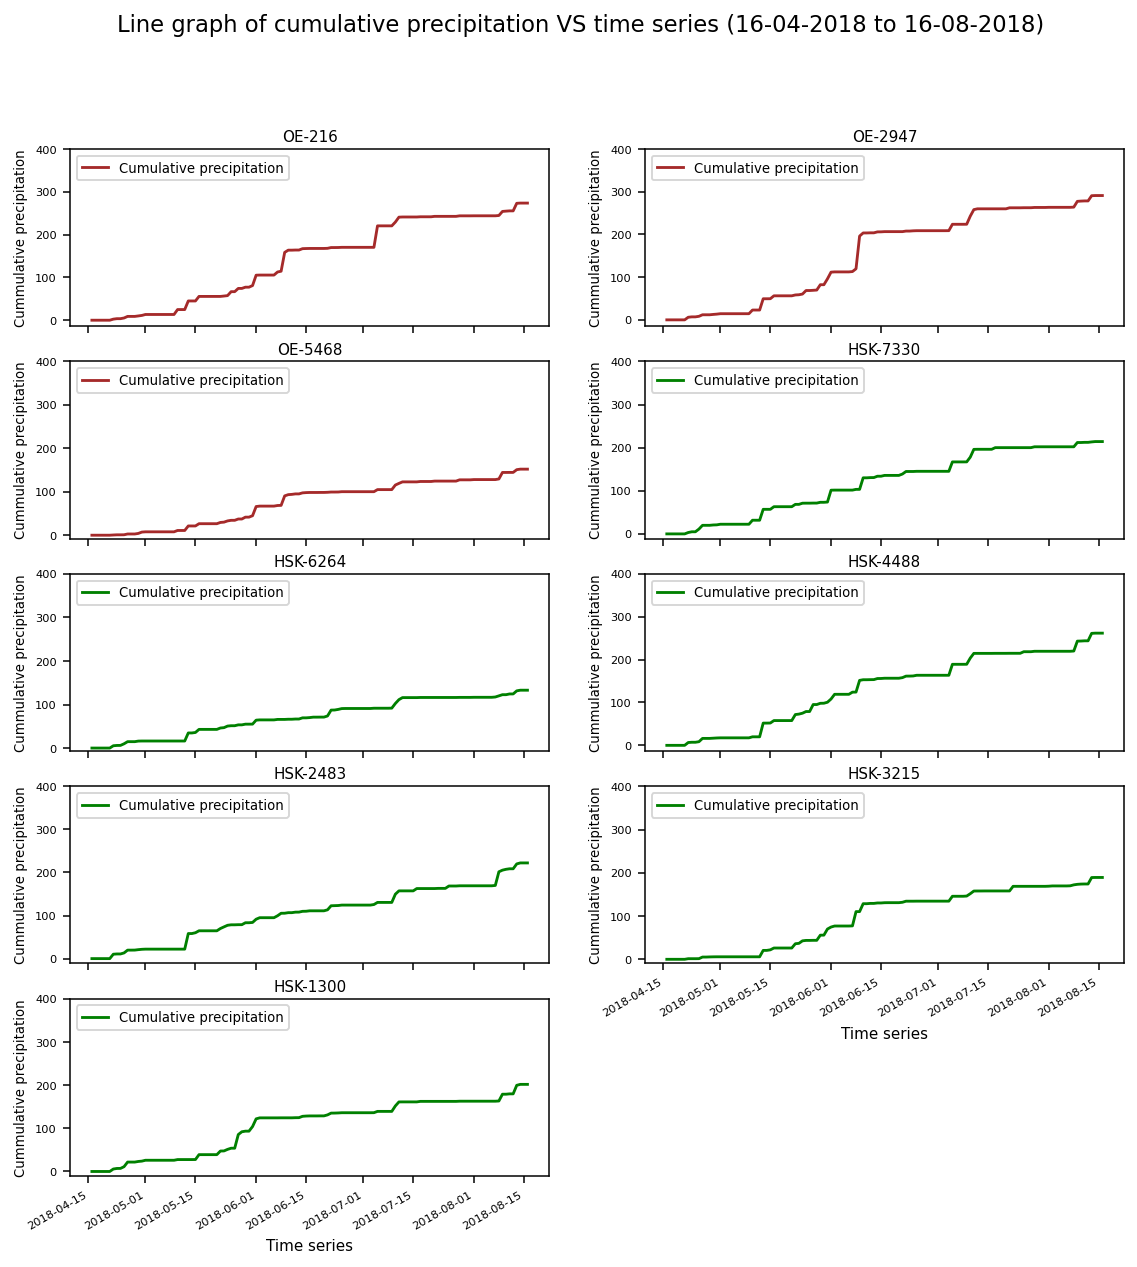

In [40]:
fig = plt.figure(dpi= 136, figsize=(10,10))
ax1 = fig.add_subplot(521)
ax2 = fig.add_subplot(522)
ax3 = fig.add_subplot(523)
ax4 = fig.add_subplot(524)
ax5 = fig.add_subplot(525)
ax6 = fig.add_subplot(526)
ax7 = fig.add_subplot(527)
ax8 = fig.add_subplot(528)
ax9 = fig.add_subplot(529)

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax4.set_xticklabels([])
ax5.set_xticklabels([])
ax6.set_xticklabels([])
ax7.set_xticklabels([])

ax1.set_ylabel('Cummulative precipitation', fontsize=7)
ax4.set_ylabel('Cummulative precipitation', fontsize=7)
ax7.set_ylabel('Cummulative precipitation', fontsize=7)

ax2.set_ylabel('Cummulative precipitation', fontsize=7)
ax3.set_ylabel('Cummulative precipitation', fontsize=7)
ax5.set_ylabel('Cummulative precipitation', fontsize=7)
ax6.set_ylabel('Cummulative precipitation', fontsize=7)
ax8.set_ylabel('Cummulative precipitation', fontsize=7)
ax9.set_ylabel('Cummulative precipitation', fontsize=7)

ax8.set_xlabel('Time series', fontsize=8)
ax9.set_xlabel('Time series', fontsize=8)

plt.setp(ax8.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax9.get_xticklabels(), rotation=30, horizontalalignment='right')

ax1.yaxis.set_tick_params(labelsize=6)
ax2.yaxis.set_tick_params(labelsize=6)
ax3.yaxis.set_tick_params(labelsize=6)
ax4.yaxis.set_tick_params(labelsize=6)
ax5.yaxis.set_tick_params(labelsize=6)
ax6.yaxis.set_tick_params(labelsize=6)
ax7.yaxis.set_tick_params(labelsize=6)
ax8.yaxis.set_tick_params(labelsize=6)
ax9.yaxis.set_tick_params(labelsize=6)

ax7.xaxis.set_tick_params(labelsize=6)
ax8.xaxis.set_tick_params(labelsize=6)
ax9.xaxis.set_tick_params(labelsize=6)

ax1.plot(total_cumsum.index.values, total_cumsum[216], color='brown')
ax2.plot(total_cumsum.index.values, total_cumsum[2947], color='brown')
ax3.plot(total_cumsum.index.values, total_cumsum[5468], color='brown')
ax4.plot(total_cumsum.index.values, total_cumsum[7330], color='green')
ax5.plot(total_cumsum.index.values, total_cumsum[6264], color='green')
ax6.plot(total_cumsum.index.values, total_cumsum[4488], color='green')
ax7.plot(total_cumsum.index.values, total_cumsum[2483], color='green')
ax8.plot(total_cumsum.index.values, total_cumsum[3215], color='green')
ax9.plot(total_cumsum.index.values, total_cumsum[1300], color='green')

ax1.set(yticks=list(range(0,500,100)))
ax2.set(yticks=list(range(0,500,100)))
ax3.set(yticks=list(range(0,500,100)))
ax4.set(yticks=list(range(0,500,100)))
ax5.set(yticks=list(range(0,500,100)))
ax6.set(yticks=list(range(0,500,100)))
ax7.set(yticks=list(range(0,500,100)))
ax8.set(yticks=list(range(0,500,100)))
ax9.set(yticks=list(range(0,500,100)))

ax1.legend(['Cumulative precipitation'],prop={'size': 7}, loc=2)
ax2.legend(['Cumulative precipitation'],prop={'size': 7}, loc=2)
ax3.legend(['Cumulative precipitation'],prop={'size': 7}, loc=2)
ax4.legend(['Cumulative precipitation'],prop={'size': 7}, loc=2)
ax5.legend(['Cumulative precipitation'],prop={'size': 7}, loc=2)
ax6.legend(['Cumulative precipitation'],prop={'size': 7}, loc=2)
ax7.legend(['Cumulative precipitation'],prop={'size': 7}, loc=2)
ax8.legend(['Cumulative precipitation'],prop={'size': 7}, loc=2)
ax9.legend(['Cumulative precipitation'],prop={'size': 7}, loc=2)

fig.suptitle('Line graph of cumulative precipitation VS time series (16-04-2018 to 16-08-2018)')

ax1.text(x=0.5, y=1.025, s='OE-216', fontsize=8, weight='normal', ha='center', va='bottom', transform=ax1.transAxes)
ax2.text(x=0.5, y=1.025, s='OE-2947', fontsize=8, weight='normal', ha='center', va='bottom', transform=ax2.transAxes)
ax3.text(x=0.5, y=1.025, s='OE-5468', fontsize=8, weight='normal', ha='center', va='bottom', transform=ax3.transAxes)
ax4.text(x=0.5, y=1.025, s='HSK-7330', fontsize=8, weight='normal', ha='center', va='bottom', transform=ax4.transAxes)
ax5.text(x=0.5, y=1.025, s='HSK-6264', fontsize=8, weight='normal', ha='center', va='bottom', transform=ax5.transAxes)
ax6.text(x=0.5, y=1.025, s='HSK-4488', fontsize=8, weight='normal', ha='center', va='bottom', transform=ax6.transAxes)
ax7.text(x=0.5, y=1.025, s='HSK-2483', fontsize=8, weight='normal', ha='center', va='bottom', transform=ax7.transAxes)
ax8.text(x=0.5, y=1.025, s='HSK-3215', fontsize=8, weight='normal', ha='center', va='bottom', transform=ax8.transAxes)
ax9.text(x=0.5, y=1.025, s='HSK-1300', fontsize=8, weight='normal', ha='center', va='bottom', transform=ax9.transAxes)

plt.savefig('C:/Users/tazbi/Downloads/Geoinformatics/Exam/MIE_2.02_WS2021_II_Exam-master/exercise_4/Line graph of cumulative precipitation VS time series')

plt.show()